# Specialist 5 Layer CNN Models

In this notebook we build several CNN models each trained to predict different facial keypoint sets. The rationale for such approach is that each keypoint contains different number of label observations. Some images show face on the side, thus not all keypoints are revealed. In order to fully utilize labels, other than just examples where full set of keypoints are marked, keypoints close to each other and which number of observations are relatively close are trained with a CNN. This gives us several CNN models. The final prediction is done via all CNNs.

In [1]:
## Architecture

print("Layer (type)                  Output Shape              Param #          Param Shape       ")
print("===========================================================================================")
print("conv2d_1 (Conv2D)             (None, 32, 96, 96)        800              (32, 1, 5, 5)     ")
print("maxpooling2d_1 (Pooling)      (None, 32, 48, 48)        0                                  ")
print("dropout_1 (Dropout)           (None, 32, 48, 48)        0                                  ") 
print("conv2d_2 (Conv2D)             (None, 64, 48, 48)        51200            (64, 32, 5, 5)    ")
print("maxpooling2d_2 (Pooling)      (None, 64, 24, 24)        0                                  ")
print("dropout_2 (Dropout)           (None, 64, 24, 24)        0                                  ")
print("conv2d_3 (Conv2D)             (None, 128, 24, 24)       204800           (128, 64, 5, 5)   ")
print("maxpooling2d_3 (Pooling)      (None, 128, 12, 12)       0                                  ")
print("dropout_3 (Dropout)           (None, 128, 12, 12)       0                                  ")
print("conv2d_4 (Conv2D)             (None, 256, 12, 12)       819200           (256, 128, 5, 5)  ")
print("maxpooling2d_4 (Pooling)      (None, 256, 6, 6)         0                                  ")
print("dropout_4 (Dropout)           (None, 256, 6, 6)         0                                  ")
print("conv2d_5 (Conv2D)             (None, 512, 6, 6)         3276800          (512, 256, 5, 5)  ")
print("maxpooling2d_5 (Pooling)      (None, 512, 3, 3)         0                                  ")
print("dropout_5 (Dropout)           (None, 512, 3, 3)         0                                  ")
print("flatten_1 (Flatten)           (None, 4608)              0                                  ")
print("dense_1 (Dense)               (None, 600)               2764800          (4608, 600)       ")
print("dense_2 (Dense)               (None, 600)               360000           (600, 600)        ")
print("dense_3 (Dense)               (None, 600)               360000           (600, 600)        ")
print("dense_4 (Dense)               (None, 600)               360000           (600, 600)        ")
print("dense_5 (Dense)               (None, 4 keypoints)       2400             (600, 4 keypoints)")
print("===========================================================================================")
print("Toal params: 8,200,000")
print("Trainable params: 8,200,000")
print("Non-trainable params: 0")

Layer (type)                  Output Shape              Param #          Param Shape       
conv2d_1 (Conv2D)             (None, 32, 96, 96)        800              (32, 1, 5, 5)     
maxpooling2d_1 (Pooling)      (None, 32, 48, 48)        0                                  
dropout_1 (Dropout)           (None, 32, 48, 48)        0                                  
conv2d_2 (Conv2D)             (None, 64, 48, 48)        51200            (64, 32, 5, 5)    
maxpooling2d_2 (Pooling)      (None, 64, 24, 24)        0                                  
dropout_2 (Dropout)           (None, 64, 24, 24)        0                                  
conv2d_3 (Conv2D)             (None, 128, 24, 24)       204800           (128, 64, 5, 5)   
maxpooling2d_3 (Pooling)      (None, 128, 12, 12)       0                                  
dropout_3 (Dropout)           (None, 128, 12, 12)       0                                  
conv2d_4 (Conv2D)             (None, 256, 12, 12)       819200           (256, 1

In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from six.moves import cPickle

from sklearn.metrics import classification_report
import time

## Theano
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.pool import pool_2d

## Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import Dropout, Flatten, Merge
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.initializers import glorot_uniform, he_uniform
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint

from collections import OrderedDict
import conv_net_helper as helper

import pydot
import h5py

print("- Device:", theano.config.device)
print("- Float", theano.config.floatX)
print("- System Version:", sys.version)
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
hello = tf.constant("Hello, TensorFlow!")
print(sess.run(hello))

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/home/ec2-user/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:556: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
Using TensorFlow backend.


- Device: gpu
- Float float64
- System Version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
b'Hello, TensorFlow!'


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## Function to plot model performance
def plot_model_performance(data):
    plt.plot(data.history['loss'], linewidth=3, label='train')
    plt.plot(data.history['val_loss'], linewidth=3, label='validation')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.ylim(1e-4, 1e-2)
    plt.yscale('log')
    plt.show()

## General Pre-trained Model

In [3]:
def pretrain_model(epochs, train_data, train_labels, dev_data, dev_labels):
    start = 0.03
    stop = 0.001
    batch_size = 128
    
    model = Sequential()
    
    ## 1st Conv Layer - Input
    model.add( Conv2D( 32, (3, 3), padding='valid', activation='relu',
                       data_format = 'channels_first',
                       kernel_initializer=glorot_uniform(),
                       input_shape=(1,96, 96) ))
    model.add( MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add( Dropout(np.cast['float32'](0.1)))  
    
    ## 2nd Conv Layer
    model.add( Conv2D( 64, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first', 
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.2))) 

    ## 3rd Conv Layer
    model.add( Conv2D( 128, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first', 
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3)))  
    
    ## 4th Conv Layer
    model.add( Conv2D( 256, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first', 
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3))) 
    
    ## 5th Conv Layer
    model.add( Conv2D( 512, (2, 2), padding='valid', activation='relu',
                       data_format = 'channels_first',
                       kernel_initializer=glorot_uniform() ))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3)))
    
    ## Flatten
    model.add(Flatten())
    
    ## Dense Layers
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dense(30))
    
    rmsprop = RMSprop(lr=np.cast['float32'](0.01), rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=np.cast['float32'](0.01) , momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    
    early_stop = EarlyStopping(patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    data =  model.fit( train_data, train_labels, 
                       batch_size = batch_size,
                       epochs=epochs, 
                       validation_data=(dev_data, dev_labels),
                       callbacks=[change_lr, early_stop] )
    
    
    plot_model_performance(data)
    helper.save_model(model, "5Layer_CNN_Pretrain_Model")
    return model

## Specialist Model

In [7]:
def train_specialist(keypoints_name, cols, 
                     epochs = 200 , start = 0.005, stop = 0.0001,
                     prefix = '5Layer_CNN_Specialist_Model',
                     batch_size = 128,
                     saved_model = None):
    
    print('Training model for columns {0} for {1} epochs'.format(cols, epochs))
    X, Y = helper.load2d(cols=cols)
    train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,Y)
    model_name = '{0}_{1}'.format(prefix, keypoints_name)
    
    use_pre = True
    if saved_model is not None:
        if os.path.isfile(saved_model):
            print('Weights saved')
            use_pre = False
        else:
            print('NO Saved weights available')
    else:
        print('NO Saved weights available')
        
    model = helper.retrieve_model('5Layer_CNN_Pretrain_Model', weights=use_pre)
    helper.pop_layer(model)
    model.add(Dense(len(cols),name=cols[0]))
    
    if not use_pre:
        print('Loading saved weights...')
        model.load_weights(saved_model)
    
    rmsprop = RMSprop(lr=np.cast['float32'](0.01), rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = SGD(lr=np.cast['float32'](0.01), momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    early_stop = EarlyStopping(monitor='val_loss', patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    path = model_name + "_weights_epoch-{epoch:02d}.h5"  
    check_point = ModelCheckpoint(path, period=100, verbose=1) 

    data =  model.fit(train_data, train_labels, 
                      batch_size = batch_size,
                      epochs=epochs, 
                      validation_data=(dev_data, dev_labels),
                      callbacks=[change_lr, early_stop, check_point])

    helper.save_model(model,model_name)
    plot_model_performance(data)
    #helper.get_error(model,dev_data, dev_labels)
    return model    

--------

## Train General Model


#### Load data 

- Load training and dev data
- Separate training data for specialised models

In [6]:
X, Y = helper.load2d()
train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,Y)

Loading data...
Loading data Done


#### Training general model with 5 layer CNN

Train on 1712 samples, validate on 428 samples
Epoch 1/500
1712/1712 [==============================] - 143s - loss: 0.1082 - val_loss: 0.0599
Epoch 2/500
1712/1712 [==============================] - 145s - loss: 0.0196 - val_loss: 0.0354
Epoch 3/500
1712/1712 [==============================] - 144s - loss: 0.0103 - val_loss: 0.0225
Epoch 4/500
1712/1712 [==============================] - 142s - loss: 0.0078 - val_loss: 0.0166
Epoch 5/500
1712/1712 [==============================] - 143s - loss: 0.0069 - val_loss: 0.0130
Epoch 6/500
1712/1712 [==============================] - 142s - loss: 0.0063 - val_loss: 0.0106
Epoch 7/500
1712/1712 [==============================] - 142s - loss: 0.0060 - val_loss: 0.0089
Epoch 8/500
1712/1712 [==============================] - 143s - loss: 0.0058 - val_loss: 0.0077
Epoch 9/500
1712/1712 [==============================] - 142s - loss: 0.0056 - val_loss: 0.0070
Epoch 10/500
1712/1712 [==============================] - 143s - loss: 0.0054 - val_loss:

1712/1712 [==============================] - 142s - loss: 0.0045 - val_loss: 0.0043
Epoch 86/500
1712/1712 [==============================] - 143s - loss: 0.0045 - val_loss: 0.0043
Epoch 87/500
1712/1712 [==============================] - 143s - loss: 0.0045 - val_loss: 0.0043
Epoch 88/500
1712/1712 [==============================] - 142s - loss: 0.0045 - val_loss: 0.0043
Epoch 89/500
1712/1712 [==============================] - 142s - loss: 0.0045 - val_loss: 0.0043
Epoch 90/500
1712/1712 [==============================] - 143s - loss: 0.0045 - val_loss: 0.0043
Epoch 91/500
1712/1712 [==============================] - 142s - loss: 0.0045 - val_loss: 0.0043
Epoch 92/500
1712/1712 [==============================] - 142s - loss: 0.0045 - val_loss: 0.0043
Epoch 93/500
1712/1712 [==============================] - 143s - loss: 0.0045 - val_loss: 0.0043
Epoch 94/500
1712/1712 [==============================] - 143s - loss: 0.0045 - val_loss: 0.0043
Epoch 95/500
1712/1712 [===================

1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 252/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 253/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 254/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 255/500
1712/1712 [==============================] - 143s - loss: 0.0044 - val_loss: 0.0043
Epoch 256/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 257/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 258/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 259/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 260/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 261/500
1712/1712 [=========

1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 419/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 420/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 421/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 422/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 423/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 424/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 425/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 426/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 427/500
1712/1712 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0042
Epoch 428/500
1712/1712 [===================

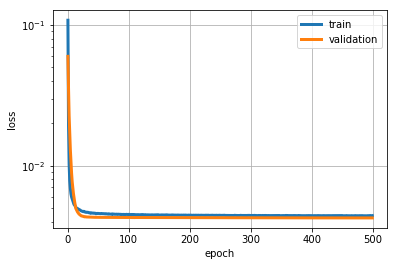

In [ ]:
pretrain_model = pretrain_model(500, train_data, train_labels, dev_data, dev_labels)

In [47]:
pretrain_model.layers
## double check after trained weight shape on each layer
# print(pretrain_model.layers[0].get_weights()[0].shape)

In [31]:
plot_model(pretrain_model, to_file='5Layer_CNN_Pretrain_Model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

----------

## Train Specialist


#### Define columns of keypoint groups for specialist training

- eye center
- nose
- mouth
- mouth_bottom
- eye corner
- eyebrow

In [5]:
## Column names of keypoint sets
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
        ),
        flip_indices=((0, 2), (1, 3)),
    ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
        ),
        flip_indices=(),
    ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
        ),
        flip_indices=((0, 2), (1, 3)),
    ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
        ),
        flip_indices=(),
    ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
        ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
    ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
        ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
    ),
]

#### Col 1 - Eye Center

In [6]:
cols = SPECIALIST_SETTINGS[0]['columns']
eyect_specialist = train_specialist("eyect", cols = cols, epochs = 50, batch_size = 64)

Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 50 epochs
Loading data...
Loading data Done
NO Saved weights available
Retrieving model: 5Layer_CNN_Pretrain_Model
Train on 5626 samples, validate on 1407 samples
Epoch 1/50
5626/5626 [==============================] - 247s - loss: 0.0120 - val_loss: 0.0051
Epoch 2/50
5626/5626 [==============================] - 247s - loss: 0.0042 - val_loss: 0.0051
Epoch 3/50
5626/5626 [==============================] - 247s - loss: 0.0042 - val_loss: 0.0051
Epoch 4/50
5626/5626 [==============================] - 247s - loss: 0.0042 - val_loss: 0.0051
Epoch 5/50
5626/5626 [==============================] - 247s - loss: 0.0042 - val_loss: 0.0051
Epoch 6/50
5626/5626 [==============================] - 247s - loss: 0.0042 - val_loss: 0.0051
Epoch 7/50
5626/5626 [==============================] - 247s - loss: 0.0042 - val_loss: 0.0051
Epoch 8/50
5626/5626 [==============================] 

AttributeError: module 'conv_net_helper' has no attribute 'plot_model_performance'

#### Col 2 - Nose

In [ ]:
cols = SPECIALIST_SETTINGS[1]['columns']
nose_specialist = train_specialist("nose", cols = cols, epochs = 50, batch_size = 64)

#### Col 3 - Mouth

In [ ]:
cols = SPECIALIST_SETTINGS[2]['columns']
mouth_specialist = train_specialist("mouth", cols = cols, epochs = 50, batch_size = 64)

#### Col 4 - Mouth Bottom

In [ ]:
cols = SPECIALIST_SETTINGS[3]['columns']
mouth_bottom_specialist = train_specialist("mouth_bottom", cols = cols,
                                           epochs = 50, batch_size = 64)

#### Col 5 - Eye Corner

In [ ]:
cols = SPECIALIST_SETTINGS[4]['columns']
eyecr_specialist = train_specialist("eyecr", cols = cols, epochs = 50, batch_size = 64)

#### Col 6 - Eyebrow

In [ ]:
cols = SPECIALIST_SETTINGS[5]['columns']
eyebrow_specialist = train_specialist("eyebrow", cols = cols, epochs = 50, batch_size = 64)


## Codes below this line are no longer valid !!

------------------

#### Subset Traing Data - for keypoint sets

In [4]:
train_data_sep = [0 for i in cols_dict.keys()]
train_labels_sep = [0 for i in cols_dict.keys()]
for i, key in enumerate(cols_dict.keys()):
    train_data_sep[i], train_labels_sep[i] = helper.subset_data(train_data,
                                                                train_labels,
                                                                full_keypoints,
                                                                cols_dict[key])

#### Subset Dev Data - for keypoint sets

In [5]:
dev_data_sep = [0 for i in cols_dict.keys()]
dev_labels_sep = [0 for i in cols_dict.keys()]
for i, key in enumerate(cols_dict.keys()):
    dev_data_sep[i], dev_labels_sep[i] = helper.subset_data(dev_data,
                                                                dev_labels,
                                                                full_keypoints,
                                                                cols_dict[key])

Reshape training and dev data into tensor 4D

In [6]:
print("training set shape, dev set shape")
for i in range(len(train_data_sep)):
    train_data_sep[i] = helper.load_2d_images(train_data_sep[i], 96)
    dev_data_sep[i] = helper.load_2d_images(dev_data_sep[i], 96)
    print(train_data_sep[i].shape, dev_data_sep[i].shape)

training set shape, dev set shape
(6030, 1, 96, 96) (1003, 1, 96, 96)
(1929, 1, 96, 96) (318, 1, 96, 96)
(1878, 1, 96, 96) (312, 1, 96, 96)
(6042, 1, 96, 96) (1007, 1, 96, 96)
(1941, 1, 96, 96) (322, 1, 96, 96)
(1950, 1, 96, 96) (325, 1, 96, 96)
(6016, 1, 96, 96) (1000, 1, 96, 96)


### Build separate CNN models

- 0: eye center
- 1: eye corner
- 2: eyebrow
- 3: nose
- 4: mouse corner
- 5: mouse center top
- 6: mouse center bottom

## 5 Layer Convnet - 1

In [11]:
numModels = len(train_data_sep)
cnns = [0. for i in range(numModels)]

for i in range(numModels):
    numClasses = train_labels_sep[i][1].size
    cnns[i] = helper.convNetBuilder(numClasses, patchSize = [5,5], 
                                   featureMapLayers = [32,64,128,256,512],
                                   numHiddenNodes = 600, numNNLayer = 5,
                                   imageWidth = 96, poolingSize = 2,
                                   train_dropout_rate = [0.2,0.5])

In [12]:
## Validate the parameters' matrix shape
for i in range(numModels):
    print("-----------------")
    for j in range(len(cnns[i].params)):
        print(cnns[i].params[j].get_value().shape)

-----------------
(32, 1, 5, 5)
(64, 32, 5, 5)
(128, 64, 5, 5)
(256, 128, 5, 5)
(512, 256, 5, 5)
(4608, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 4)
-----------------
(32, 1, 5, 5)
(64, 32, 5, 5)
(128, 64, 5, 5)
(256, 128, 5, 5)
(512, 256, 5, 5)
(4608, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 8)
-----------------
(32, 1, 5, 5)
(64, 32, 5, 5)
(128, 64, 5, 5)
(256, 128, 5, 5)
(512, 256, 5, 5)
(4608, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 8)
-----------------
(32, 1, 5, 5)
(64, 32, 5, 5)
(128, 64, 5, 5)
(256, 128, 5, 5)
(512, 256, 5, 5)
(4608, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 2)
-----------------
(32, 1, 5, 5)
(64, 32, 5, 5)
(128, 64, 5, 5)
(256, 128, 5, 5)
(512, 256, 5, 5)
(4608, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 4)
-----------------
(32, 1, 5, 5)
(64, 32, 5, 5)
(128, 64, 5, 5)
(256, 128, 5, 5)
(512, 256, 5, 5)
(4608, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 2)
-----------------
(32, 1, 5, 5)
(64, 32, 5, 5)
(128, 64, 5, 5)
(256, 128, 5, 5)
(512, 256, 5, 

In [13]:
train_result = [ [] for i in range(numModels) ]
val_result = [ [] for i in range(numModels) ]
model_name = ["eye center", "eye corner", "eyebrow", "nose",
              "mouth corner", "mouth center top", "mouth center bottom"]

In [ ]:
rounds = 1000
alpha_schedule = np.linspace(0.3, 0.0001, rounds)

for i, model in enumerate(cnns):
    print("\n ======================================================")
    print("CNN Model", (i+1), " - ", model_name[i], "keypoint prediction")
    train_result[i] , val_result[i] = model.SGD(train_data_sep[i], train_labels_sep[i],
                                                update_rule = "backprop",
                                                epochs = rounds, 
                                                miniBatchSize = 10,
                                                learning_rate = 0.05,
                                                learningRateSchedule = alpha_schedule,
                                                validation = [dev_data_sep[i],
                                                              dev_labels_sep[i]]
                                               )


CNN Model 1  -  eye center keypoint prediction

Epoch: 1 / 1000
training time: 880.30395484 s, ----- loss: 0.0158258945051 , RMSE: 6.03844855403
validation loss: 1.21478302394 , val RMSE: 52.9042539609

Epoch: 2 / 1000
training time: 873.586210012 s, ----- loss: 0.0158604053171 , RMSE: 6.0450288544
validation loss: 1.17748362595 , val RMSE: 52.0857204443

Epoch: 3 / 1000
training time: 882.13487339 s, ----- loss: 0.0184171028083 , RMSE: 6.51406208677
validation loss: 1.17156091347 , val RMSE: 51.9545603833

Epoch: 4 / 1000
training time: 760.372305155 s, ----- loss: 0.0107313276227 , RMSE: 4.97242182872
validation loss: 1.10928991295 , val RMSE: 50.5549597906

Epoch: 5 / 1000
training time: 497.775071859 s, ----- loss: 0.0141021642948 , RMSE: 5.70012162459
validation loss: 1.02869498341 , val RMSE: 48.6838088257

Epoch: 6 / 1000
training time: 495.802038193 s, ----- loss: 0.0138427848243 , RMSE: 5.64745750185
validation loss: 1.09384210481 , val RMSE: 50.2017152046

Epoch: 7 / 1000
tr


Epoch: 53 / 1000
training time: 499.498436928 s, ----- loss: 0.0118288135669 , RMSE: 5.22049676353
validation loss: 0.861996218366 , val RMSE: 44.5650006969

Epoch: 54 / 1000
training time: 503.695280552 s, ----- loss: 0.0117094853514 , RMSE: 5.19409802079
validation loss: 0.857425588494 , val RMSE: 44.4466934191

Epoch: 55 / 1000
training time: 497.90859127 s, ----- loss: 0.0105760187908 , RMSE: 4.93630907602
validation loss: 0.847507095229 , val RMSE: 44.1888713073


## 5 Layer Convnet - 2

In [9]:
numModels = len(train_data_sep)
cnns = [0. for i in range(numModels)]

for i in range(numModels):
    numClasses = train_labels_sep[i][1].size
    cnns[i] = helper.convNetBuilder(numClasses, patchSize = [3,3], 
                                   featureMapLayers = [32,64,128,256,512],
                                   numHiddenNodes = 600, numNNLayer = 5,
                                   imageWidth = 96, poolingSize = 2,
                                   train_dropout_rate = [0.1,0.2])

In [11]:
train_result = [ [] for i in range(numModels) ]
val_result = [ [] for i in range(numModels) ]
model_name = ["eye center", "eye corner", "eyebrow", "nose",
              "mouth corner", "mouth center top", "mouth center bottom"]

In [ ]:
rounds = 1000
alpha_schedule = np.linspace(0.3, 0.0001, rounds)

for i, model in enumerate(cnns):
    print("\n ======================================================")
    print("CNN Model", (i+1), " - ", model_name[i], "keypoint prediction")
    train_result[i] , val_result[i] = model.SGD(train_data_sep[i], train_labels_sep[i],
                                                update_rule = "backprop",
                                                epochs = rounds, 
                                                miniBatchSize = 128,
                                                learning_rate = 0.05,
                                                learningRateSchedule = alpha_schedule,
                                                validation = [dev_data_sep[i],
                                                              dev_labels_sep[i]]
                                               )


CNN Model 1  -  eye center keypoint prediction

Epoch: 1 / 1000
training time: 286.312456608 s, ----- loss: 0.0359750370572 , RMSE: 9.10420152346
validation loss: 0.29725723631 , val RMSE: 26.1702249218

Epoch: 2 / 1000
training time: 283.510923147 s, ----- loss: 0.0230057412153 , RMSE: 7.28046892446
validation loss: 0.348642423921 , val RMSE: 28.342056113

Epoch: 3 / 1000
training time: 285.698756218 s, ----- loss: 0.0181355627305 , RMSE: 6.46408048612
validation loss: 0.378655732863 , val RMSE: 29.5368043044

Epoch: 4 / 1000
training time: 284.099583626 s, ----- loss: 0.0147946539027 , RMSE: 5.83839726225
validation loss: 0.400320162036 , val RMSE: 30.3700124026

Epoch: 5 / 1000
training time: 285.617279291 s, ----- loss: 0.0156294807556 , RMSE: 6.00086024341
validation loss: 0.42169218009 , val RMSE: 31.1701585323

Epoch: 6 / 1000
training time: 284.309452057 s, ----- loss: 0.0134525553409 , RMSE: 5.56728726629
validation loss: 0.44416628638 , val RMSE: 31.9899847424

Epoch: 7 / 10


Epoch: 54 / 1000
training time: 284.807795286 s, ----- loss: 0.00905691668307 , RMSE: 4.56805604582
validation loss: 0.613962589615 , val RMSE: 37.6107671615

Epoch: 55 / 1000
training time: 284.616959572 s, ----- loss: 0.00930174395609 , RMSE: 4.6293863605
validation loss: 0.614914791665 , val RMSE: 37.6399213601

Epoch: 56 / 1000
training time: 295.596877098 s, ----- loss: 0.00962677409916 , RMSE: 4.70957402792
validation loss: 0.606920814 , val RMSE: 37.3944588871

Epoch: 57 / 1000
training time: 284.842188597 s, ----- loss: 0.0091917693687 , RMSE: 4.60193835525
validation loss: 0.607156792375 , val RMSE: 37.4017278963

Epoch: 58 / 1000
training time: 284.598899603 s, ----- loss: 0.00812979346127 , RMSE: 4.32793763065
validation loss: 0.612885993697 , val RMSE: 37.5777770694

Epoch: 59 / 1000
training time: 285.084350109 s, ----- loss: 0.00930037605834 , RMSE: 4.62904595337
validation loss: 0.607191541704 , val RMSE: 37.4027981852

Epoch: 60 / 1000
training time: 284.981537342 s, -


Epoch: 106 / 1000
training time: 284.311748981 s, ----- loss: 0.00831086060484 , RMSE: 4.37586823768
validation loss: 0.578942559083 , val RMSE: 36.5223719948

Epoch: 107 / 1000
training time: 284.484941721 s, ----- loss: 0.00831468565358 , RMSE: 4.37687511198
validation loss: 0.584603406785 , val RMSE: 36.7004938554

Epoch: 108 / 1000
training time: 284.712085962 s, ----- loss: 0.00880064867455 , RMSE: 4.50296508383
validation loss: 0.58296849009 , val RMSE: 36.64913916

Epoch: 109 / 1000
training time: 284.941594124 s, ----- loss: 0.00786030455922 , RMSE: 4.25560121539
validation loss: 0.576369314809 , val RMSE: 36.4411155334

Epoch: 110 / 1000
training time: 284.635048628 s, ----- loss: 0.00887232808122 , RMSE: 4.52126574082
validation loss: 0.577928894439 , val RMSE: 36.4903846621



### Plot performance

### Save the model params

In [ ]:
for i in range(numModels):
    for layer in range(len(cnns[i].params)):
        filename = model_name[i] + "_layer" + str(layer+1)
        helper.save_layer_params(cnns[i].params[layer], filename)

In [13]:
helper.load_saved_params("eye_ct_layer9_weights").get_value()

array([[-0.0039484 , -0.01108056,  0.00097547, ...,  0.00673776,
        -0.00781311, -0.00604274],
       [-0.01168752,  0.00146486,  0.00517273, ...,  0.00331349,
        -0.01609198,  0.00706688],
       [-0.00588158,  0.00856659, -0.00125814, ..., -0.00328748,
         0.0118611 ,  0.00234903],
       ..., 
       [-0.01497844, -0.00012292, -0.01610636, ...,  0.00627014,
         0.00585229, -0.00109457],
       [-0.01884747, -0.0079815 , -0.01920352, ..., -0.00610651,
        -0.00692251,  0.00126688],
       [-0.00646328, -0.00138179, -0.00709273, ...,  0.02022066,
         0.00733202, -0.00276212]])

----------------------------------------------------------------------